# Windowing

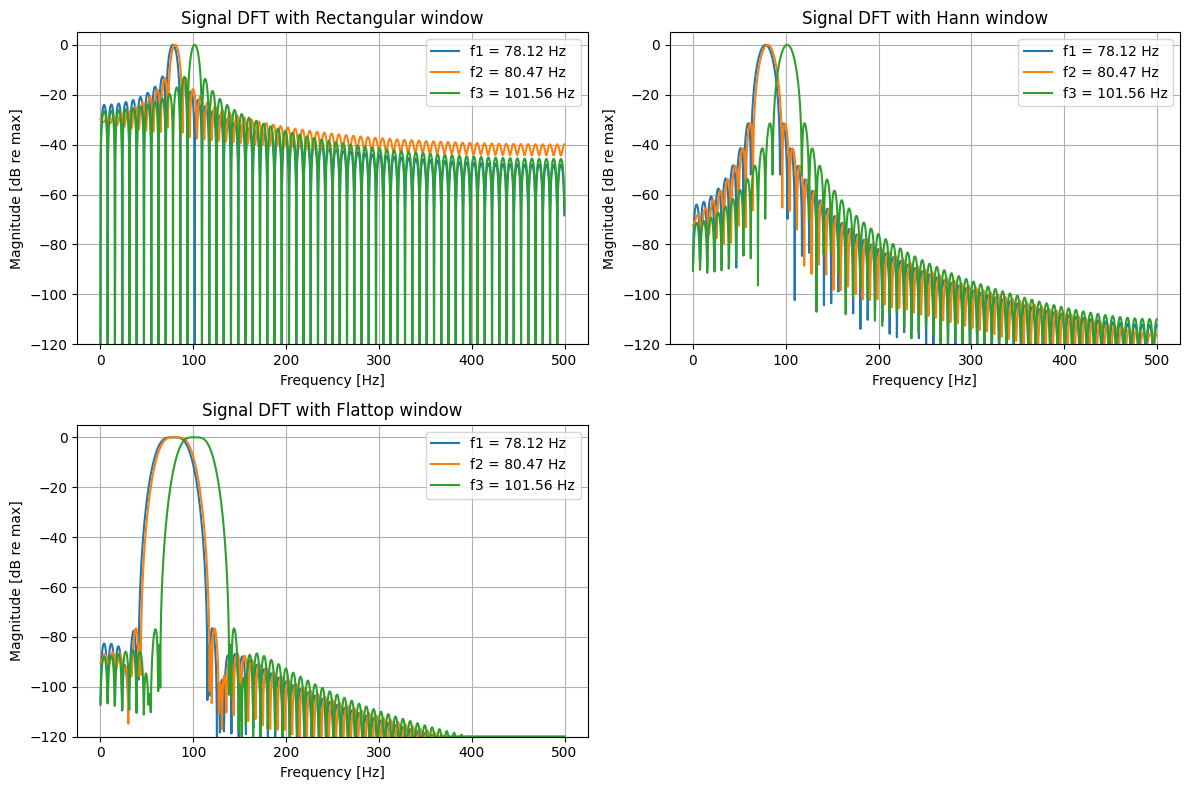

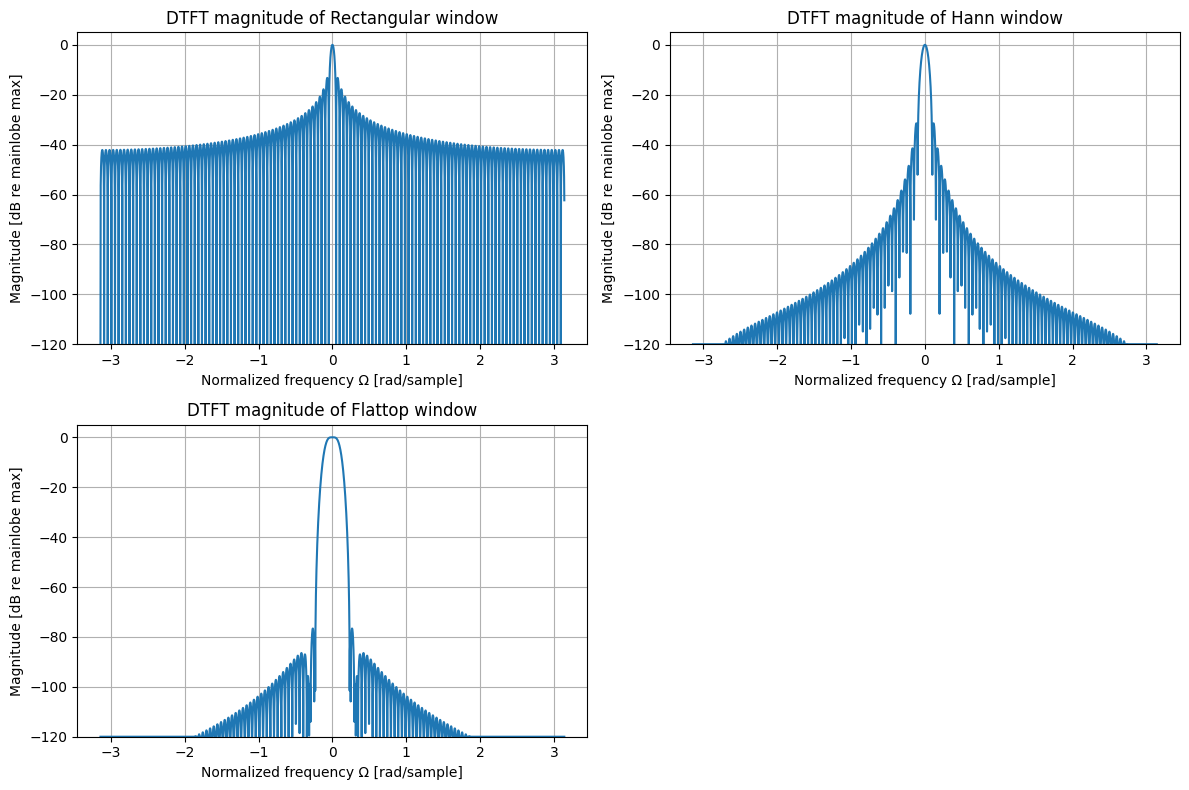

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# PARAMETERS (ADAPT TO YOUR VARIANT)
# ==========================
fs = 1000.0      # sampling frequency [Hz]
N  = 128         # number of samples

# Example frequencies (replace with your own variant):
k1 = 10                      # DFT bin index for f1
f1 = k1 * fs / N             # exactly bin-centered
f2 = f1 + 0.3 * fs / N       # slightly off-bin
f3 = f1 + 3.0 * fs / N       # another frequency a bit away

A = 1.0          # amplitude -> |x[k]|_max = A for each sinusoid
n_fft = 4096     # FFT size for smooth spectra

# ==========================
# SIGNAL GENERATION (SEPARATE)
# ==========================
k = np.arange(N)

x1 = A * np.sin(2 * np.pi * f1 * k / fs)
x2 = A * np.sin(2 * np.pi * f2 * k / fs)
x3 = A * np.sin(2 * np.pi * f3 * k / fs)

signals = {
    f"f1 = {f1:.2f} Hz": x1,
    f"f2 = {f2:.2f} Hz": x2,
    f"f3 = {f3:.2f} Hz": x3,
}

# ==========================
# CUSTOM FLATTOP WINDOW (pure NumPy, no SciPy)
# ==========================
def flattop_window(N: int) -> np.ndarray:
    """
    Standard 5-term flat-top window (Harris coefficients).
    Good for amplitude-accurate FFT measurement.
    """
    n = np.arange(N)
    a0 = 1.0
    a1 = 1.93
    a2 = 1.29
    a3 = 0.388
    a4 = 0.028
    w = (
        a0
        - a1 * np.cos(2 * np.pi * n / (N - 1))
        + a2 * np.cos(4 * np.pi * n / (N - 1))
        - a3 * np.cos(6 * np.pi * n / (N - 1))
        + a4 * np.cos(8 * np.pi * n / (N - 1))
    )
    return w

# ==========================
# WINDOWS
# ==========================
windows = {
    "Rectangular": np.ones(N),
    "Hann":        np.hanning(N),
    "Flattop":     flattop_window(N),
}

# Frequency axis for DFT (0 .. fs/2)
freq = np.linspace(0, fs, n_fft, endpoint=False)
half = n_fft // 2
freq_half = freq[:half]

# ==========================
# HELPER: MAGNITUDE TO dB
# ==========================
def mag2db(x, min_db=-120):
    mag = np.abs(x)
    mag = np.maximum(mag, 1e-12)  # avoid log(0)
    db = 20 * np.log10(mag)
    db = np.maximum(db, min_db)
    return db

# ==========================
# 1. NORMALIZED DFT SPECTRA OF EACH SIGNAL
#    (each signal treated separately)
# ==========================
plt.figure(figsize=(12, 8))

for i, (wname, w) in enumerate(windows.items(), start=1):
    plt.subplot(2, 2, i)

    for sname, x in signals.items():
        xw = x * w

        X = np.fft.fft(xw, n=n_fft)
        X = X[:half]

        # Normalize spectrum of THIS signal+window to its own max
        X_norm = X / np.max(np.abs(X))
        X_db = mag2db(X_norm)

        plt.plot(freq_half, X_db, label=sname)

    plt.title(f"Signal DFT with {wname} window")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB re max]")
    plt.ylim([-120, 5])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# 2. WINDOW DTFT SPECTRA (NORMALIZED TO MAINLOBE MAX)
# ==========================
plt.figure(figsize=(12, 8))

for i, (wname, w) in enumerate(windows.items(), start=1):
    W = np.fft.fft(w, n=n_fft)
    W = np.fft.fftshift(W)  # center zero frequency
    W_norm = W / np.max(np.abs(W))  # normalize to mainlobe max
    W_db = mag2db(W_norm)

    # Normalized frequency axis in rad/sample (−π..π)
    omega = np.linspace(-np.pi, np.pi, n_fft, endpoint=False)

    plt.subplot(2, 2, i)
    plt.plot(omega, W_db)
    plt.title(f"DTFT magnitude of {wname} window")
    plt.xlabel("Normalized frequency Ω [rad/sample]")
    plt.ylabel("Magnitude [dB re mainlobe max]")
    plt.ylim([-120, 5])
    plt.grid(True)

plt.tight_layout()
plt.show()


## How to interpret the results
1. Best vs. Worst Windows (in this set)

Look at the window DTFT plots:

- Rectangular Window

Narrowest mainlobe → best ability to separate close frequencies.

Very high sidelobes (≈ –13 dB) → strongest spectral leakage.

Conclusion: Best resolution, worst leakage.

- Hann Window

Mainlobe is wider than rectangular.

Sidelobes are much lower (≈ –31 dB).

Conclusion: Good compromise — acceptable resolution and significantly reduced leakage.

- Flattop Window

Very wide mainlobe.

Sidelobes relatively low and “flat” across the top.

Designed for highly accurate amplitude measurement (very small scalloping loss).

Poor frequency resolution because peaks are broad.



Now check the signal spectra:

- Rectangular window:
Sharp peaks for bin-centered frequencies, but very strong sidelobes for off-bin frequencies → heavy leakage.

- Hann window:
Peaks become wider, but leakage is much lower.

- Flattop window:
Peaks are broad and rounded, but their height is very close to the true amplitude → excellent amplitude accuracy, poor resolution.

Summary

Best frequency resolution: Rectangular

Best compromise: Hann

Best amplitude accuracy: Flattop (but worst for resolving nearby tones)


In [1]:
! pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
